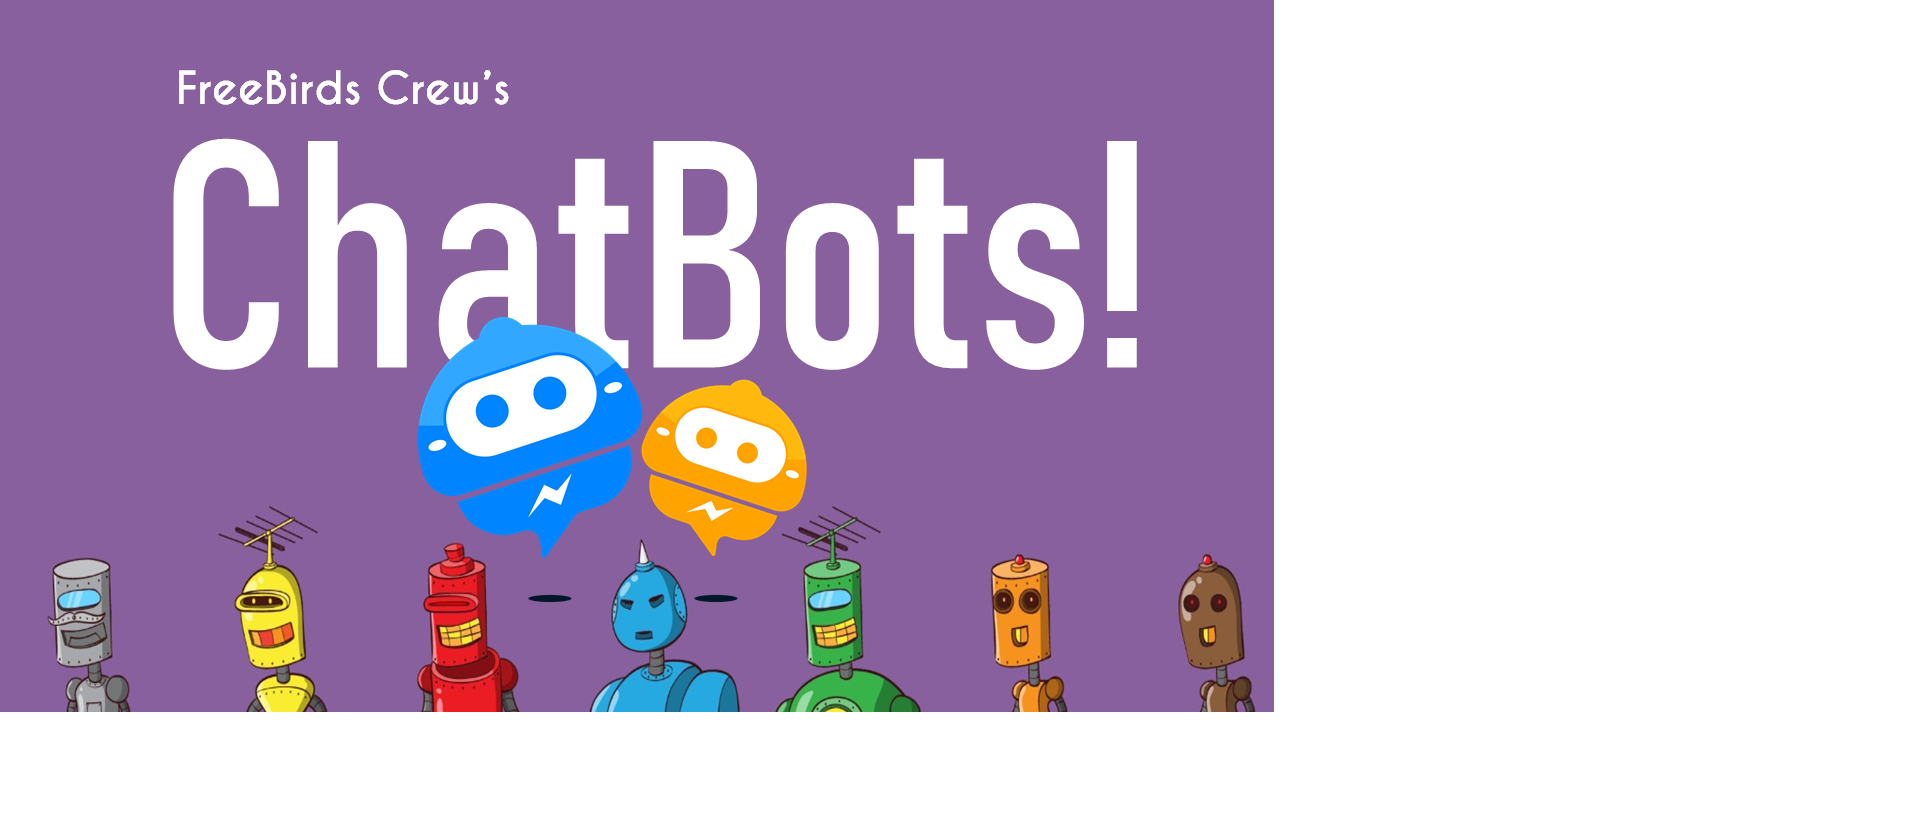

In [1]:
from IPython.core.display import Image, display
display(Image('Untitled.png'))


In [2]:
import numpy as np
import tensorflow as tf
import tflearn
import random

#Usde to for Contextualisation and Other NLP Tasks.
import nltk
from nltk.stem.lancaster import LancasterStemmer
stemmer = LancasterStemmer()

#Other
import json
import pickle
import warnings
warnings.filterwarnings("ignore")

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [3]:
print("Processing the Intents.....")
with open('intents.json') as json_data:
    intents = json.load(json_data)

Processing the Intents.....


In [4]:
words = []
classes = []
documents = []
ignore_words = ['?']
print("Looping through the Intents to Convert them to words, classes, documents and ignore_words.......")
for intent in intents['intents']:
    for pattern in intent['patterns']:
        # tokenize each word in the sentence
        w = nltk.word_tokenize(pattern)
        # add to our words list
        words.extend(w)
        # add to documents in our corpus
        documents.append((w, intent['tag']))
        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

Looping through the Intents to Convert them to words, classes, documents and ignore_words.......


LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/english.pickle[0m

  Searched in:
    - 'C:\\Users\\Ganesh/nltk_data'
    - 'c:\\Users\\Ganesh\\AppData\\Local\\Programs\\Python\\Python36\\nltk_data'
    - 'c:\\Users\\Ganesh\\AppData\\Local\\Programs\\Python\\Python36\\share\\nltk_data'
    - 'c:\\Users\\Ganesh\\AppData\\Local\\Programs\\Python\\Python36\\lib\\nltk_data'
    - 'C:\\Users\\Ganesh\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - ''
**********************************************************************


In [ ]:
print("Stemming, Lowering and Removing Duplicates.......")
words = [stemmer.stem(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

# remove duplicates
classes = sorted(list(set(classes)))

print (len(documents), "documents")
print (len(classes), "classes", classes)
print (len(words), "unique stemmed words", words)

In [ ]:
print("Creating the Data for our Model.....")
training = []
output = []
print("Creating an List (Empty) for Output.....")
output_empty = [0] * len(classes)

print("Creating Traning Set, Bag of Words for our Model....")
for doc in documents:
    # initialize our bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # stem each word
    pattern_words = [stemmer.stem(word.lower()) for word in pattern_words]
    # create our bag of words array
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)

    # output is a '0' for each tag and '1' for current tag
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    training.append([bag, output_row])

In [ ]:
print("Shuffling Randomly and Converting into Numpy Array for Faster Processing......")
random.shuffle(training)
training = np.array(training)

print("Creating Train and Test Lists.....")
train_x = list(training[:,0])
train_y = list(training[:,1])
print("Building Neural Network for Out Chatbot to be Contextual....")
print("Resetting graph data....")
tf.reset_default_graph()

In [ ]:
net = tflearn.input_data(shape=[None, len(train_x[0])])
net = tflearn.fully_connected(net, 8)
net = tflearn.fully_connected(net, 8)
net = tflearn.fully_connected(net, len(train_y[0]), activation='softmax')
net = tflearn.regression(net)
print("Training....")

In [ ]:
print("Training the Model.......")
model.fit(train_x, train_y, n_epoch=1000, batch_size=8, show_metric=True)
print("Saving the Model.......")
model.save('model.tflearn')

In [ ]:
print("Pickle is also Saved..........")
pickle.dump( {'words':words, 'classes':classes, 'train_x':train_x, 'train_y':train_y}, open( "training_data", "wb" ) )

In [ ]:
print("Loading Pickle.....")
data = pickle.load( open( "training_data", "rb" ) )
words = data['words']
classes = data['classes']
train_x = data['train_x']
train_y = data['train_y']


with open('intents.json') as json_data:
    intents = json.load(json_data)
    
print("Loading the Model......")
# load our saved model
model.load('./model.tflearn')

In [ ]:
def clean_up_sentence(sentence):
    # It Tokenize or Break it into the constituents parts of Sentense.
    sentence_words = nltk.word_tokenize(sentence)
    # Stemming means to find the root of the word.
    sentence_words = [stemmer.stem(word.lower()) for word in sentence_words]
    return sentence_words

# Return the Array of Bag of Words: True or False and 0 or 1 for each word of bag that exists in the Sentence
def bow(sentence, words, show_details=False):
    sentence_words = clean_up_sentence(sentence)
    bag = [0]*len(words)
    for s in sentence_words:
        for i,w in enumerate(words):
            if w == s:
                bag[i] = 1
                if show_details:
                    print ("found in bag: %s" % w)
    return(np.array(bag))

ERROR_THRESHOLD = 0.25
print("ERROR_THRESHOLD = 0.25")

def classify(sentence):
    # Prediction or To Get the Posibility or Probability from the Model
    results = model.predict([bow(sentence, words)])[0]
    # Exclude those results which are Below Threshold
    results = [[i,r] for i,r in enumerate(results) if r>ERROR_THRESHOLD]
    # Sorting is Done because heigher Confidence Answer comes first.
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append((classes[r[0]], r[1])) #Tuppl -> Intent and Probability
    return return_list
def response(sentence, userID='123', show_details=False):
    results = classify(sentence)
    # That Means if Classification is Done then Find the Matching Tag.
    if results:
        # Long Loop to get the Result.
        while results:
            for i in intents['intents']:
                # Tag Finding
                if i['tag'] == results[0][0]:
                    # Random Response from High Order Probabilities
                    return print(random.choice(i['responses']))

            results.pop(0)

In [ ]:
das

In [ ]:
while True:
    input_data = input("You- ")
    answer = response(input_data)
    answer